# Analyzing GOOG, AAPL & FB 2010-2020

In [194]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from pandas_datareader import data as pdr
from datetime import date, timedelta
import yfinance as yf
import os
from pathlib import Path
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error

In [59]:
yf.pdr_override()

In [124]:
STOCKS = ["AAPL", "GOOG", "FB"]
LAST_N_DAYS = 10 * 365
DATADIR = "data"
SIGNIFICANCE_LEVEL = 0.05

In [96]:
!mkdir -p $DATADIR

In [100]:
today = date.today()
start_date = today - timedelta(days=LAST_N_DAYS)

dfs = dict()

for stock in STOCKS:
    filename = Path(DATADIR) / f"{stock}_{today}.csv"
    if filename.exists():
        dfs[stock] = pd.read_csv(filename).set_index("Date")
    else:
        dfs[stock] = pdr.get_data_yahoo(stock, start=start_date, end=today)
        dfs[stock].to_csv(filename)

In [101]:
df = pd.DataFrame({k: v.Close for k, v in dfs.items()})

In [105]:
returns = (df.shift(-1) - df) / df

In [203]:
returns.head()

,AAPL,GOOG,FB
2010-04-29,-0.028105,-0.011842,NaN
2010-04-30,0.020146,0.009321,NaN
2010-05-03,-0.028797,-0.045665,NaN
2010-05-04,-0.010399,0.006695,NaN
2010-05-05,-0.038048,-0.021755,NaN


In [106]:
returns.describe()

,AAPL,GOOG,FB
count,2514.000000,2514.000000,1995.000000
mean,0.000947,0.000758,0.001077
std,0.017424,0.016251,0.023487
min,-0.128647,-0.111008,-0.189609
25%,-0.007135,-0.006508,-0.009120
50%,0.000756,0.000520,0.001020
75%,0.009821,0.008615,0.011884
max,0.119808,0.160524,0.296115


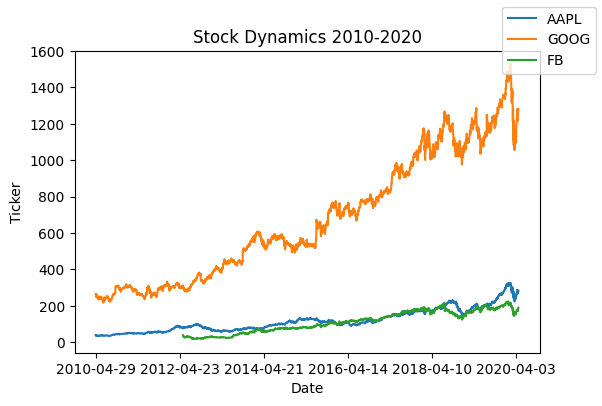

In [118]:
fig = plt.figure(dpi=100)
for stock in STOCKS:
    ax = sns.lineplot(x=df.index, y=df[stock])
fig.legend(labels=STOCKS)
plt.ylabel("Ticker")
plt.xlabel("Date")
ax.set_xticks(ax.get_xticks()[::500])
plt.title("Stock Dynamics 2010-2020")
plt.show()

In [127]:
for stock in STOCKS:
    X = df[stock].dropna().values
    result = adfuller(X)
    if result[1] < SIGNIFICANCE_LEVEL:
        print(f"{stock} is stationary by the Augmented Dickey-Fuller test.")
    else:
        print(f"{stock} is NOT stationary by the Augmented Dickey-Fuller test.")

AAPL is NOT stationary by the Augmented Dickey-Fuller test.
GOOG is NOT stationary by the Augmented Dickey-Fuller test.
FB is NOT stationary by the Augmented Dickey-Fuller test.


## Autocorrelation Analysis

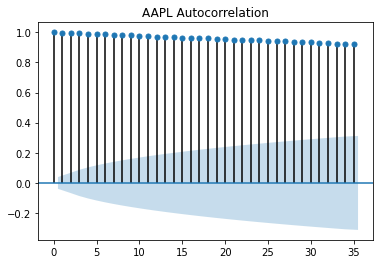

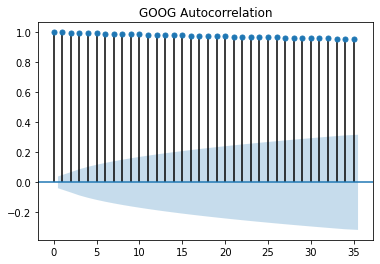

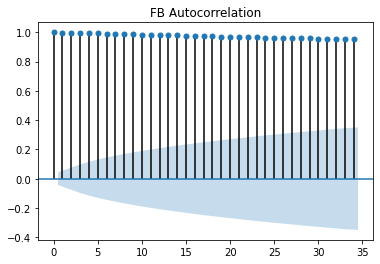

In [136]:
for stock in STOCKS:
    X = df[stock].dropna()
    plot_acf(X, title=f"{stock} Autocorrelation")
    plt.show()

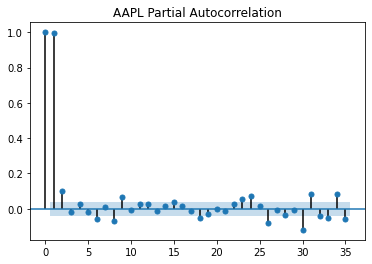

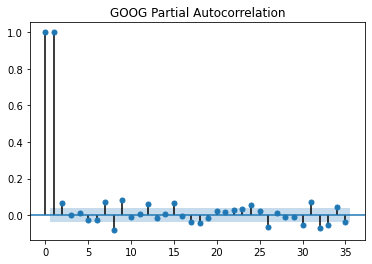

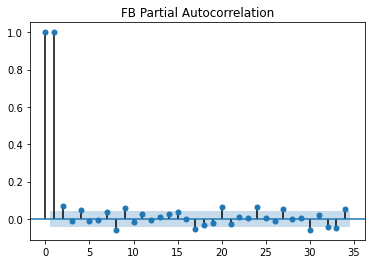

In [137]:
for stock in STOCKS:
    X = df[stock].dropna()
    plot_pacf(X, title=f"{stock} Partial Autocorrelation")
    plt.show()

## Profit & Loss

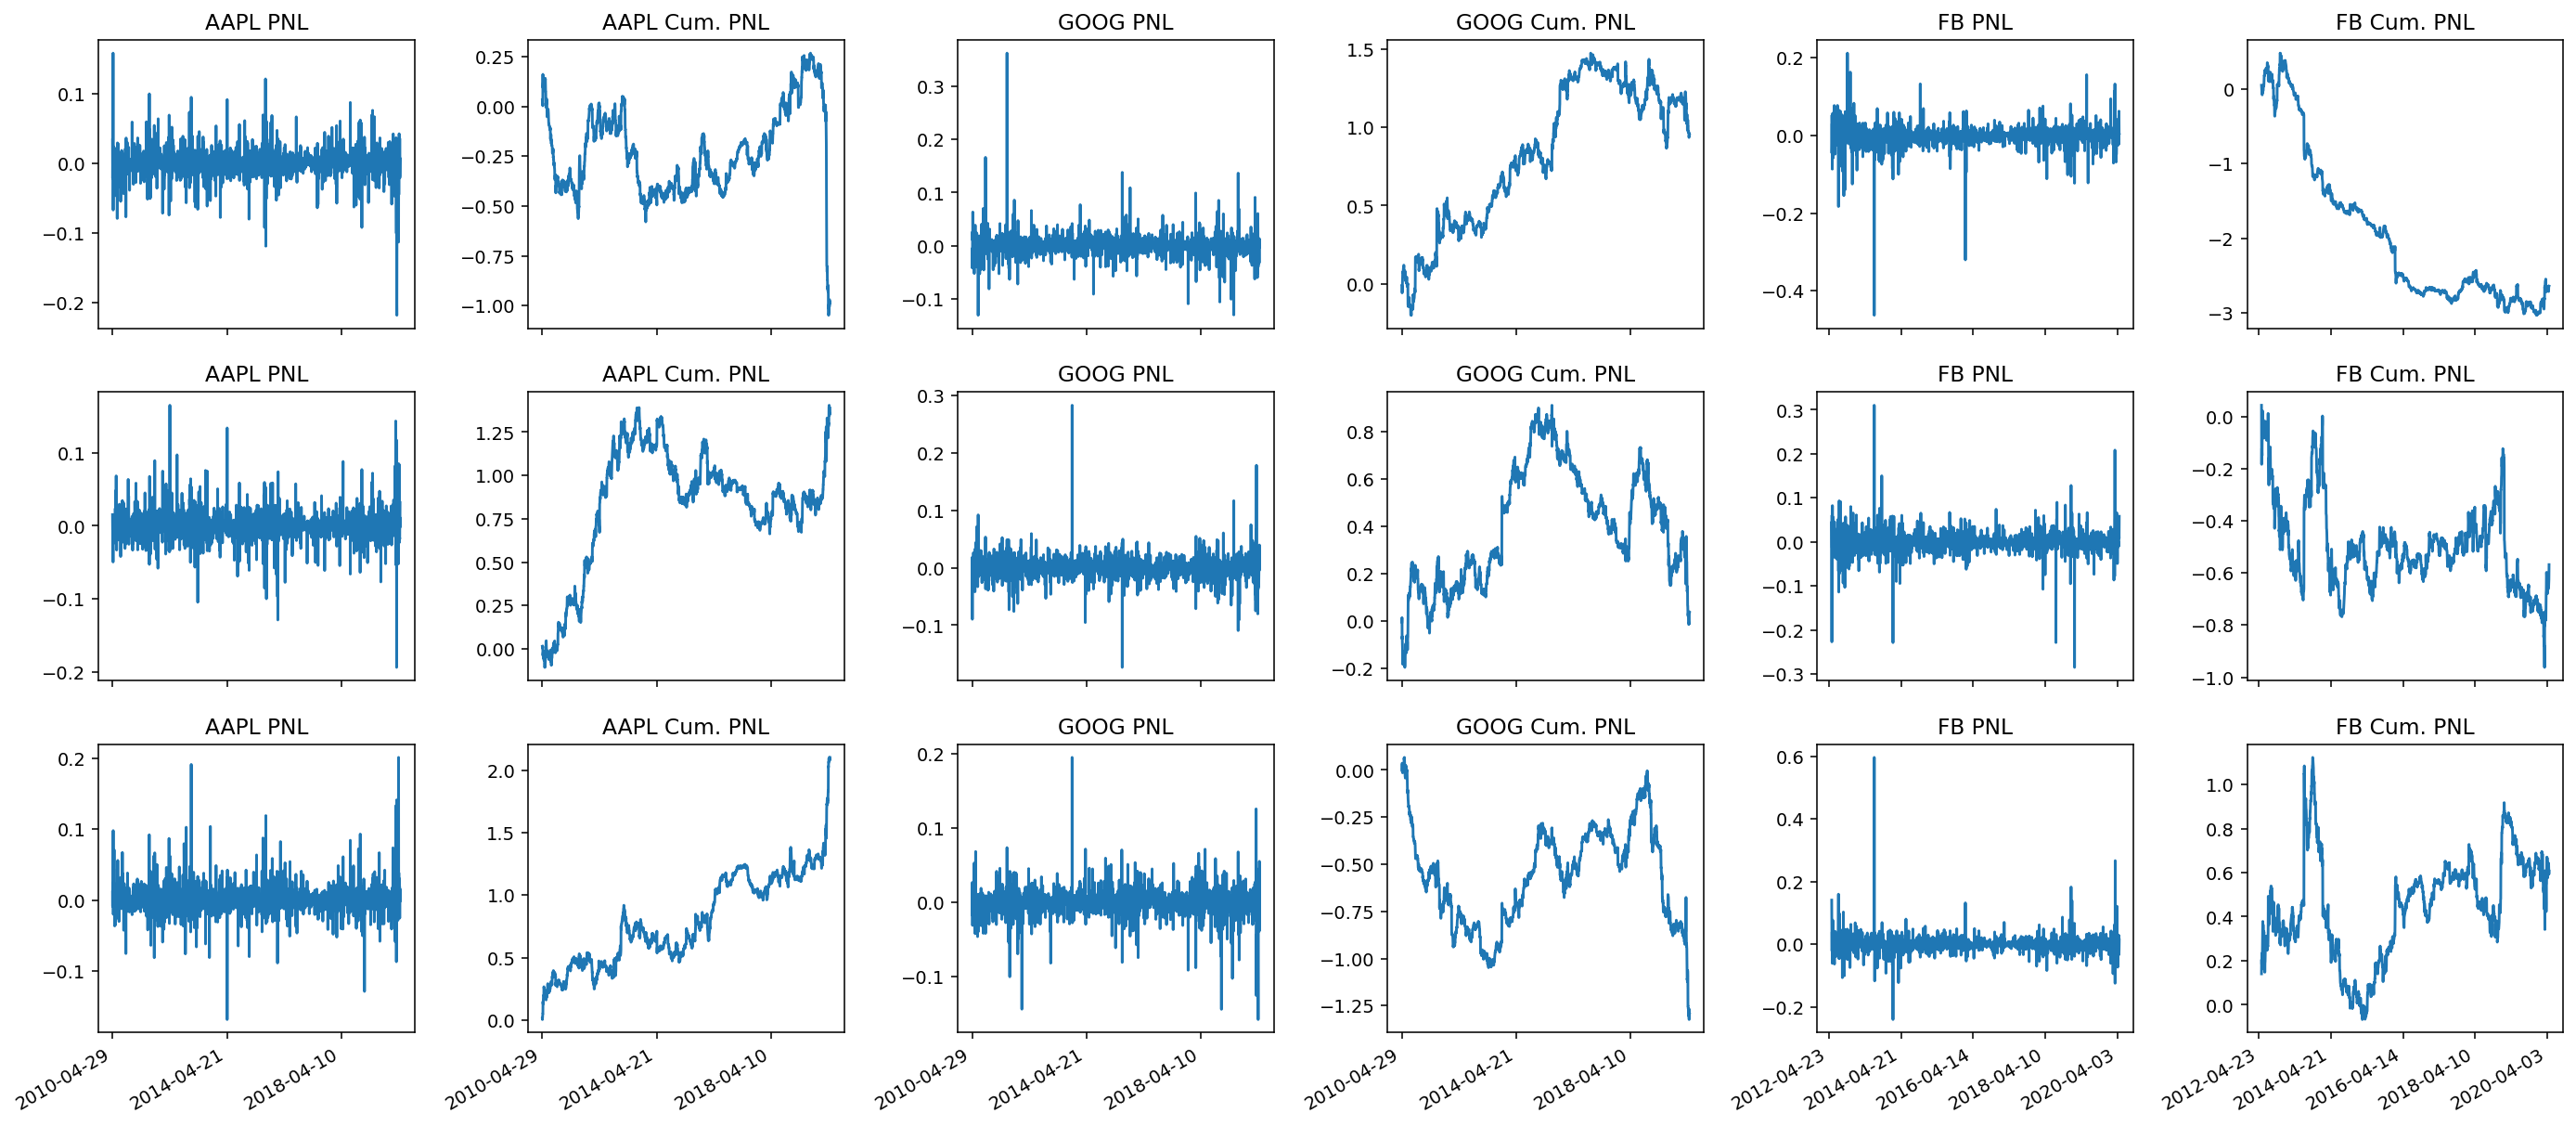

In [179]:
def model_pnl(n_models):
    fig = plt.figure(dpi=140, figsize=(20, 10))
    idx = 0
    for model_idx in range(n_models):
        pnl = returns * np.random.normal(size=returns.shape)
        for stock_idx, stock in enumerate(STOCKS):
            idx += 1
            plt.subplot(n_models, len(STOCKS) * 2, idx)
            pnl[stock].plot(title=f"{stock} PNL")
            idx += 1
            plt.subplot(n_models, len(STOCKS) * 2, idx)
            pnl[stock].cumsum().plot(title=f"{stock} Cum. PNL")
    plt.tight_layout()
    fig.autofmt_xdate()
    plt.show()


model_pnl(3)

## Scratchpad

In [210]:
def hit_rate(returns, prediction):
    return (np.sign(prediction) == np.sign(returns)).mean(axis=1)

/Users/sdll/miniconda3/envs/py3.7/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


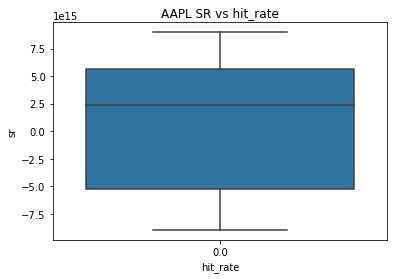

/Users/sdll/miniconda3/envs/py3.7/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


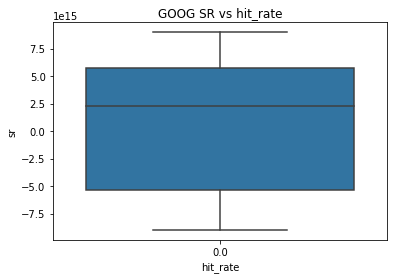

/Users/sdll/miniconda3/envs/py3.7/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


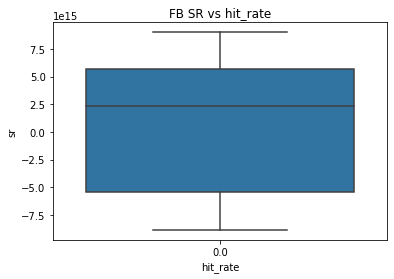

In [216]:
def approximate_sharpe_ratio(series):
    return series.mean(axis=1) / series.std(axis=1)


def plot_sharpe_ratio(returns, n_draws=1000, acc="hit_rate"):
    for stock in STOCKS:
        stock_returns = returns[stock].dropna()
        sim_stock_pnl = pd.DataFrame({draw: stock_returns for draw in range(n_draws)})
        
        plt.title(f"{stock} SR vs {acc}")
        plt.xlabel(acc)
        plt.ylabel("SR")
        
        if acc == "hit_rate":
            data = pd.DataFrame(
                {
                    "sr": approximate_sharpe_ratio(sim_stock_pnl),
                    "hit_rate": hit_rate(stock_returns, sim_stock_pnl),
                },
                index=sim_stock_pnl.index
            )
        elif acc == "rmse":
            data = pd.DataFrame(
                {
                    "sr": approximate_sharpe_ratio(sim_stock_pnl),
                    "rmse": mean_squared_error(stock_returns, sim_stock_pnl),
                }
            )
            
        sns.boxplot(x="hit_rate", y="sr", data=data)
        plt.show()


plot_sharpe_ratio(returns, acc="hit_rate")

In [ ]:
from alpha_vantage.timeseries import TimeSeries
from ipython_secrets import get_secret

In [ ]:
ALPHA_VANTAGE_API_KEY = get_secret("ALPHA_VANTAGE_API_KEY")

In [20]:
ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format="pandas", indexing_type="date")

In [28]:
def build_df(stocks=STOCKS):
    cols = dict()
    for stock in stocks:
        data, meta = ts.get_daily(symbol=stock, outputsize="full")
        cols[stock] = data.rename(columns={"4. close": "close"})["close"]
    return pd.DataFrame(cols)


df = build_df()

In [37]:
now = datetime.datetime.now()
train_df = df[now - df.index <= datetime.timedelta(days=LAST_N_DAYS)]